<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Binomal_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################################
## This script will simulate data from known statistical distributions; then estimate GAN and sample from it
##mar 3 3pm copy
## Authors: Betty and Chris, ft David
## Date: February 2023
############################################

In [2]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 718.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 44.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 7.3 MB/s eta 0:00:00
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none

In [3]:
########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

In [4]:
## Set seed of everything, the best will be to set them once and run all the notebook
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

In [5]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathematical Theory
##
#####################################

In [6]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [7]:
## Sample size by math
def samp_size_bin_ci(alpha, proportion, width):
    n = (4 * (scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)**2) * proportion*(1-proportion) / (width**2))
    return n

In [8]:
samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1) ##245.8534

245.8533645244241

In [9]:
#################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by numerical simulation
##
################################

In [10]:
def bin_ci_samp_size(n, p, size):
    ## Generate random data
    x = np.random.binomial(n= 1, p = 0.2, size = 245)
    ## Analyze generated/simulated data
    k = np.sum(x)
    n = len(x)
    res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
    mu_hat = np.mean(x)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})
    
    return(out)

In [11]:
bin_ci_samp_size(n=1, p=0.2, size=245)

,mean,ll95_mean,ul95_mean
0,0.216327,0.166444,0.273213


In [12]:
## Replicate above function number of simulation replicate times

# parameter available  
n = int(np.ceil(samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1)))
p = 0.2


## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(bin_ci_samp_size(n=1, p=p, size=n))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate means of each column in the array #axis means column mean 
sim_means = np.mean(sim_df, axis=0)

#Calculate the width of the confidence interval
ci_width = sim_means[2] - sim_means[1]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [sim_means[0]],
    'mean_ll95': [sim_means[1]],
    'mean_ul95': [sim_means[2]],
    'ci_width': [ci_width]
})

sim_results

,runtime,mean_hat,mean_ll95,mean_ul95,ci_width
0,96.988327,0.200175,0.152092,0.255673,0.103581


In [14]:
#############################################################
##
## Sample size estimation by GAN simulation
##
#############################################################

In [15]:
## Function to train a GAN model to simulated binormal data (with parms: p, size)
def train_gan_model_binormal(pop_n, pop_p, pop_size):
    ## Set seed of everything, ONLY FOR THE GAN 
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = np.random.binomial(n= pop_n, p = pop_p, size = pop_size)
    
    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

In [16]:
# %%time
%%capture output

## Parameters of binormal parent distribution
p=0.2
n = 10000

## Get the learned GAN model --- after training 
t0 = time()
train_gan = train_gan_model_binormal(pop_n=1, pop_p=p, pop_size=n)
t1 = time()
fit_time = t1 - t0
fit_time

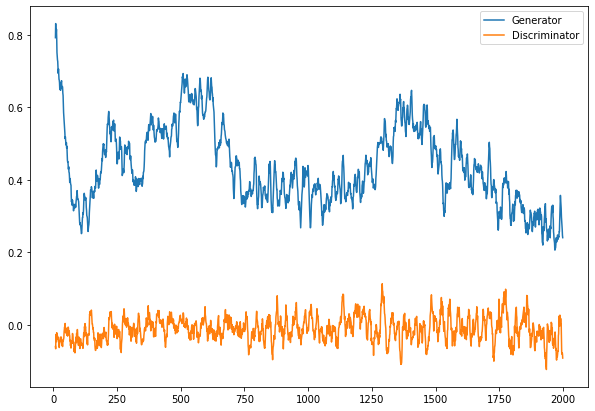

In [17]:
logs = StringIO(str(output))
window = 10 # window size for the moving average, window=1 gets you the original series

df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

plt.figure(figsize=(10,7))

# Plot with a moving average so it is less noisy
plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

plt.legend()
plt.show()

In [18]:
model_ = train_gan[0]

In [19]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x
count,10000.000000
mean,0.201000
std,0.400768
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [20]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1)))
sim_n

246

In [21]:
## Function to analyze data from the sampled model 
def binorm_ci_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    x = m.sample(num_rows=sim_n)
    ## Analyze generated/simulated data
    #k = np.sum(x).round(0).astype('int')
    k = np.sum(x)
    k = int(k)
    n = len(x)
    p = 0.2
    res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
    mu_hat = np.mean(x)
   
    # Return the estimate and the CI to the user
    out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
    return(out)

In [22]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(binorm_ci_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_means = np.mean(gan_df, axis=0)

## Calculate the width of the confidence interval
gan_width = gan_means[2] - gan_means[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [gan_means[0]],
    'mean_ll95': [gan_means[1]],
    'mean_ul95': [gan_means[2]],
    'ci_width': [gan_width]
})

gan_results

,runtime,mean_hat,mean_ll95,mean_ul95,ci_width
0,25.142357,0.198988,0.151067,0.254323,0.103255


In [24]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [25]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05], 
              'p': np.arange(0.1, 0.5, 0.1), 
              'width': [0.05,0.1,0.15,0.20,0.25]}

param_df = expand_grid(dictionary)
param_df

,alpha,p,width
0,0.05,0.1,0.05
1,0.05,0.1,0.10
2,0.05,0.1,0.15
3,0.05,0.1,0.20
4,0.05,0.1,0.25
5,0.05,0.2,0.05
6,0.05,0.2,0.10
7,0.05,0.2,0.15
8,0.05,0.2,0.20
9,0.05,0.2,0.25


In [26]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_bin_ci(alpha=param_df.loc[i, 'alpha'], 
                          proportion=param_df.loc[i, 'p'],
                          width=param_df.loc[i, 'width'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','p','width','n_theory']
samp_size_theory_df

,alpha,p,width,n_theory
0,0.05,0.1,0.05,554.0
1,0.05,0.1,0.10,139.0
2,0.05,0.1,0.15,62.0
3,0.05,0.1,0.20,35.0
4,0.05,0.1,0.25,23.0
5,0.05,0.2,0.05,984.0
6,0.05,0.2,0.10,246.0
7,0.05,0.2,0.15,110.0
8,0.05,0.2,0.20,62.0
9,0.05,0.2,0.25,40.0


In [27]:
########################
## 2) Sample Size for Continuous CI by Simulation from binormal Distribution
########################

In [28]:
def binorm_ci_samp_size(n, p, size):    
    ## Generate random data
    x = np.random.binomial(n= 1, p = p, size = size)
    ## Analyze generated/simulated data
    k = np.sum(x)
    n = len(x)
    res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
    mu_hat = np.mean(x)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})
    
    return(out)


In [29]:
binorm_ci_samp_size(n=1, p=0.2, size=245)

,mean,ll95_mean,ul95_mean
0,0.195918,0.148131,0.251227


In [30]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def binorm_ci_samp_size_sim( p, size, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        sim_out.append(binorm_ci_samp_size(n=1, p=p, size=size))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_means = np.mean(sim_df, axis=0)

    ## Calculate the width of the confidence interval
    ci_width = sim_means[2] - sim_means[1]

    ## Return expect width 
    return ci_width

In [31]:
binorm_ci_samp_size_sim( p=0.2, size=245, n_rep=100)

  0%|          | 0/100 [00:00<?, ?it/s]

0.10254102476869004

In [32]:
## Loop over theoretical table, to use simulation to understand relationship between (n, p, size, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    ci_width = binorm_ci_samp_size_sim(size=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          p=samp_size_theory_df.loc[i, 'p'],
                          n_rep=n_rep)
    ## Round to largest integer
    ci_width_ = str(np.round(ci_width,4))
    ## Append sample size to list
    samp_size_sim_list.append(ci_width_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','p','width','n_theory','ci_width_sim']
samp_size_sim_df

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,alpha,p,width,n_theory,ci_width_sim
0,0.05,0.1,0.05,554.0,0.0516
1,0.05,0.1,0.10,139.0,0.1055
2,0.05,0.1,0.15,62.0,0.1614
3,0.05,0.1,0.20,35.0,0.2172
4,0.05,0.1,0.25,23.0,0.2714
5,0.05,0.2,0.05,984.0,0.0509
6,0.05,0.2,0.10,246.0,0.1033
7,0.05,0.2,0.15,110.0,0.156
8,0.05,0.2,0.20,62.0,0.2095
9,0.05,0.2,0.25,40.0,0.2613


In [33]:
## Timing for the simulation experiments
sim_time

1641.446439743042

In [34]:
########################
## 3) Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution
########################

In [35]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_binormal(pop_p, pop_size):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = np.random.binomial(n=1, p=pop_p, size=pop_size)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=False, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

In [36]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def binorm_ci_samp_size_gan(pop_p, pop_size, n_rep):

    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_binormal(pop_p=pop_p, pop_size=pop_size)
    t1 = time()
    fit_time = t1 - t0
    #fit_time
    
    ## Extract learned GAN model
    model_ = train_gan[0]

    ## Function to analyze data from the sampled model 
    def binorm_ci_samp_size_gan(m, pop_size):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        x = m.sample(num_rows=pop_size)
        ## Analyze generated/simulated data
        k = np.sum(x)
        k = int(k)
        n = len(x)
        res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')
    
        ## Extract the estimate and CI
        mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
        mu_hat = np.mean(x)
 
        # Return the estimate and the CI to the user
        out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
        return(out)
    
    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(binorm_ci_samp_size_gan(m=model_, pop_size=pop_size))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_means = np.mean(gan_df, axis=0)

    ## Calculate the width of the confidence interval
    gan_width = gan_means[2] - gan_means[1]

    ## Return the GAN estimated CI width
    return gan_width

In [37]:
##
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

t0 = time()

tmp = binorm_ci_samp_size_gan(pop_p=0.2, pop_size=int(np.ceil(samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1))), 
                              n_rep=1000)

t1 = time()

[tmp, t1-t0]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0.10493861298273069, 50.077701568603516]

In [38]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    ci_width = binorm_ci_samp_size_gan(
                      pop_p=samp_size_theory_df.loc[i, 'p'], 
                      pop_size=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                      n_rep=n_rep)
    ## Round to largest integer
    ci_width_ = str(np.round(ci_width,4))
    ## Append sample size to list
    samp_size_gan_list.append(ci_width_)

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','p','width','n_theory','ci_width_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,p,width,n_theory,ci_width_gan
0,0.05,0.1,0.05,554.0,0.0533
1,0.05,0.1,0.10,139.0,0.1057
2,0.05,0.1,0.15,62.0,0.1693
3,0.05,0.1,0.20,35.0,0.2057
4,0.05,0.1,0.25,23.0,0.3187
5,0.05,0.2,0.05,984.0,0.0491
6,0.05,0.2,0.10,246.0,0.1049
7,0.05,0.2,0.15,110.0,0.1644
8,0.05,0.2,0.20,62.0,0.1977
9,0.05,0.2,0.25,40.0,0.2857


In [39]:
#gan_time

In [40]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [41]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-08'

In [42]:
## Session Info
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.5.3
numpy       1.22.4
pandas      1.3.5
scipy       1.10.1
sdv         0.18.0
seaborn     0.11.2
sinfo       0.3.4
torch       1.13.1+cu116
tqdm        4.64.1
-----
IPython             7.9.0
jupyter_client      6.1.12
jupyter_core        5.2.0
notebook            6.3.0
-----
Python 3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]
Linux-5.10.147+-x86_64-with-glibc2.29
2 logical CPU cores, x86_64
-----
Session information updated at 2023-03-08 16:00


In [43]:
## Jupyter version
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.9.0
ipykernel        : 5.3.4
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 5.2.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.2
nbconvert        : 6.5.4
nbformat         : 5.7.3
notebook         : 6.3.0
qtconsole        : not installed
traitlets        : 5.7.1


In [44]:
## Python version
!python --version

Python 3.8.10
